<h1 style="color:gold;">Importations</h1>


In [29]:
#Importations des modules nécessaires

import pandas as pd
import shap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import networkx as nx
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import clone
from tqdm import tqdm
import xgboost as xgb
import pandas as pd
import gc

c:\Users\gwelo\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
#Importation des données

chemin_fichier = r"C:\Users\gwelo\OneDrive\Documents\3A\UE D\hotel_bookings.csv"
df = pd.read_csv(chemin_fichier, sep=',', encoding='utf-8')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

<h1 style="color:gold;">Traitement des données</h1>


In [13]:
cols_to_drop = ["arrival_date_year", "arrival_date_week_number", "arrival_date_day_of_month", "agent", "company", "reservation_status_date", "reservation_status", "distribution_channel"]

df = df.drop(columns=cols_to_drop, errors="ignore")

def mois_vers_saison(mois):
    mois = mois.strip().lower()
    if mois in ["december", "january", "february"]:
        return "Hiver"
    elif mois in ["march", "april", "may"]:
        return "Printemps"
    elif mois in ["june", "july", "august"]:
        return "Été"
    elif mois in ["september", "october", "november"]:
        return "Automne"

df["arrival_season"] = df["arrival_date_month"].apply(mois_vers_saison)
df = df.drop(columns=["arrival_date_month"])

print(df["arrival_season"].value_counts())


def country_to_zone(code):
    if code == "PRT":
        return "Natif"
    
    continent_mapping = {
        "Europe": ["ALB","AND","AUT","BEL","BGR","BIH","BLR","CHE","CYP","CZE","DEU","DNK",
                   "ESP","EST","FIN","FRA","GBR","GRC","HRV","HUN","IRL","ISL","ITA","LIE",
                   "LTU","LUX","LVA","MCO","MLT","MNE","NLD","NOR","POL","PRT","ROU","SMR",
                   "SRB","SVK","SVN","SWE","UKR","VAT","MKD","JEY","GGY","IMN","GIB","FRO"],
        "Asie": ["AFG","ARM","AZE","BHR","BGD","BRN","BTN","CHN","CYP","GEO","IND","IDN",
                 "IRN","IRQ","ISR","JOR","JPN","KAZ","KWT","KGZ","LAO","LBN","LKA","MMR",
                 "MNG","MYS","NPL","OMN","PAK","PHL","QAT","SAU","SGP","KOR","SYR","TJK",
                 "THA","TLS","TUR","TKM","ARE","UZB","VNM","YEM","TWN","HKG","MAC","MDV",
                 "KHM","RUS"],
        "Amérique": ["ARG","BHS","BRB","BLZ","BOL","BRA","CAN","CHL","COL","CRI","CUB","DMA",
                     "DOM","ECU","GRD","GTM","GUY","HTI","HND","JAM","MEX","NIC","PAN","PRY",
                     "PER","SUR","TTO","URY","USA","VEN","PRI","KNA","ABW","GLP"],
        "Afrique": ["DZA","AGO","BEN","BWA","BFA","BDI","CPV","CMR","CAF","TCD","COM","COG",
                    "CIV","COD","DJI","EGY","GNQ","ERI","SWZ","ETH","GAB","GMB","GHA","GIN",
                    "GNB","KEN","LSO","LBR","LBY","MDG","MWI","MLI","MRT","MUS","MOZ","NAM",
                    "NER","NGA","RWA","STP","SEN","SYC","SLE","SOM","ZAF","SSD","SDN","TGO",
                    "UGA","TZA","ZMB","ZWE","MAR","TUN"],
        "Océanie": ["AUS","FJI","KIR","MHL","FSM","NRU","NZL","PLW","PNG","WSM","SLB","TON","TUV","VUT","TMP"]
    }
    
    for cont, codes in continent_mapping.items():
        if code in codes:
            return f"Etranger_{cont.upper()}"
    
    return "Etranger_Autre"

df["country_zone"] = df["country"].apply(country_to_zone)
print(df["country_zone"].value_counts())
df = df.drop(columns=["country"], errors="ignore")

top_market = df["market_segment"].value_counts().head(10)
print("\n🏷️ Top 10 – market_segment")
display(top_market.to_frame(name="Occurrences"))

df["room_satisfaction"] = (df["reserved_room_type"] == df["assigned_room_type"]).astype(int)
df = df.drop(columns=["reserved_room_type", "assigned_room_type"], errors="ignore")



arrival_season
Été          37477
Printemps    32674
Automne      28462
Hiver        20777
Name: count, dtype: int64
country_zone
Etranger_EUROPE      58655
Natif                48590
Etranger_AMÉRIQUE     4976
Etranger_ASIE         3770
Etranger_Autre        1782
Etranger_AFRIQUE      1111
Etranger_OCÉANIE       506
Name: count, dtype: int64

🏷️ Top 10 – market_segment


,Occurrences
market_segment,
Online TA,56477
Offline TA/TO,24219
Groups,19811
Direct,12606
Corporate,5295
Complementary,743
Aviation,237
Undefined,2


In [14]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

pd.set_option("display.max_rows", 500)  
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 500)

resume_global = {}

for col in num_cols:
    valeurs_pos = df[df[col] > 0][col]
    
    if valeurs_pos.empty:
        resume_global[col] = "Aucune valeur > 0"
        continue
    
    counts = valeurs_pos.value_counts().sort_index()
    total_lignes_pos = counts.sum()
    nb_valeurs_uniques = counts.shape[0]
    
    top_counts = counts.head(10)
    
    resume_global[col] = {
        "Nb_lignes>0": int(total_lignes_pos),
        "Nb_valeurs_uniques>0": int(nb_valeurs_uniques),
        "Top_valeurs>0": top_counts.to_dict()
    }

resume_df = pd.DataFrame(resume_global).T
display(resume_df)


,Nb_lignes>0,Nb_valeurs_uniques>0,Top_valeurs>0
is_canceled,44224,1,{1: 44224}
lead_time,113045,478,"{1: 3460, 2: 2069, 3: 1816, 4: 1715, 5: 1565, 6: 1445, 7: 1331, 8: 1138, 9: 992, 10: 976}"
stays_in_weekend_nights,67392,16,"{1: 30626, 2: 33308, 3: 1259, 4: 1855, 5: 79, 6: 153, 7: 19, 8: 60, 9: 11, 10: 7}"
stays_in_week_nights,111745,34,"{1: 30310, 2: 33684, 3: 22258, 4: 9563, 5: 11077, 6: 1499, 7: 1029, 8: 656, 9: 231, 10: 1036}"
adults,118987,13,"{1: 23027, 2: 89680, 3: 6202, 4: 62, 5: 2, 6: 1, 10: 1, 20: 2, 26: 5, 27: 2}"
children,8590,4,"{1.0: 4861, 2.0: 3652, 3.0: 76, 10.0: 1}"
babies,917,4,"{1: 900, 2: 15, 9: 1, 10: 1}"
is_repeated_guest,3810,1,{1: 3810}
previous_cancellations,6484,14,"{1: 6051, 2: 116, 3: 65, 4: 31, 5: 19, 6: 22, 11: 35, 13: 12, 14: 14, 19: 19}"
previous_bookings_not_canceled,3620,72,"{1: 1542, 2: 580, 3: 333, 4: 229, 5: 181, 6: 115, 7: 88, 8: 70, 9: 60, 10: 53}"


In [15]:
y = df["is_canceled"] 
df_features = df.drop(columns=["is_canceled"], errors="ignore")

missing_counts = df_features.isna().sum()
print("Nombre de valeurs manquantes par colonne :\n")
print(missing_counts[missing_counts > 0])

df_num = df_features.select_dtypes(include=["int64", "float64"]).copy()
df_cat = df_features.select_dtypes(include=["object", "category"]).copy()

# Augmenter les options d'affichage pour ne rien tronquer
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", None)

# Boucle pour afficher le nombre de classes et les valeurs uniques
for col in df_cat.columns:
    valeurs_uniques = df_cat[col].value_counts(dropna=False)
    print(f"\n📌 Variable : {col}")
    print(f"Nombre de classes : {valeurs_uniques.shape[0]}")
    print("Valeurs et occurrences :")
    display(valeurs_uniques)

df_num.fillna(0, inplace=True)
df_cat.fillna("Autre_NR", inplace=True)

if "arrival_season" in df_cat.columns:
    df_cat["arrival_season"] = df_cat["arrival_season"].replace({"Autre": "Autre_NR"})
if "country_zone" in df_cat.columns:
    df_cat["country_zone"] = df_cat["country_zone"].replace({"Etranger_Autre": "Autre_NR"})
if "market_segment" in df_cat.columns:
    df_cat["market_segment"] = df_cat["market_segment"].replace({"Undefined": "Autre_NR"})

scaler = StandardScaler()
df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num),columns=df_num.columns,index=df_num.index)

one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_cat_encoded = pd.DataFrame(one_hot_encoder.fit_transform(df_cat),columns=one_hot_encoder.get_feature_names_out(df_cat.columns),index=df_cat.index)

df_final = pd.concat([df_num_scaled, df_cat_encoded], axis=1)

df_final["is_canceled"] = y.values

cols = ["is_canceled"] + [col for col in df_final.columns if col != "is_canceled"]
df_final = df_final[cols]

print("\nForme finale du DataFrame transformé :", df_final.shape)
display(df_final.head())

Nombre de valeurs manquantes par colonne :

children    4
dtype: int64

📌 Variable : hotel
Nombre de classes : 2
Valeurs et occurrences :


hotel
City Hotel      79330
Resort Hotel    40060
Name: count, dtype: int64


📌 Variable : meal
Nombre de classes : 5
Valeurs et occurrences :


meal
BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: count, dtype: int64


📌 Variable : market_segment
Nombre de classes : 8
Valeurs et occurrences :


market_segment
Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: count, dtype: int64


📌 Variable : deposit_type
Nombre de classes : 3
Valeurs et occurrences :


deposit_type
No Deposit    104641
Non Refund     14587
Refundable       162
Name: count, dtype: int64


📌 Variable : customer_type
Nombre de classes : 4
Valeurs et occurrences :


customer_type
Transient          89613
Transient-Party    25124
Contract            4076
Group                577
Name: count, dtype: int64


📌 Variable : arrival_season
Nombre de classes : 4
Valeurs et occurrences :


arrival_season
Été          37477
Printemps    32674
Automne      28462
Hiver        20777
Name: count, dtype: int64


📌 Variable : country_zone
Nombre de classes : 7
Valeurs et occurrences :


country_zone
Etranger_EUROPE      58655
Natif                48590
Etranger_AMÉRIQUE     4976
Etranger_ASIE         3770
Etranger_Autre        1782
Etranger_AFRIQUE      1111
Etranger_OCÉANIE       506
Name: count, dtype: int64


Forme finale du DataFrame transformé : (119390, 49)


,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,room_satisfaction,hotel_City Hotel,hotel_Resort Hotel,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Autre_NR,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_season_Automne,arrival_season_Hiver,arrival_season_Printemps,arrival_season_Été,country_zone_Autre_NR,country_zone_Etranger_AFRIQUE,country_zone_Etranger_AMÉRIQUE,country_zone_Etranger_ASIE,country_zone_Etranger_EUROPE,country_zone_Etranger_OCÉANIE,country_zone_Natif
0,0,2.227051,-0.92889,-1.310240,0.247897,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,4.260101,-0.131924,-2.015038,-0.254873,-0.720694,0.377867,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,5.923385,-0.92889,-1.310240,0.247897,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,5.793131,-0.131924,-2.015038,-0.254873,-0.720694,0.377867,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,-0.907814,-0.92889,-0.786207,-1.478447,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,-0.131924,-0.530935,-0.254873,-0.720694,-2.646435,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,-0.851667,-0.92889,-0.786207,-1.478447,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,-0.131924,-0.530935,-0.254873,-0.720694,0.377867,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,-0.842309,-0.92889,-0.262174,0.247897,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,-0.131924,-0.075810,-0.254873,0.540666,0.377867,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<h1 style="color:gold;">Optimisation en dimensionnalité par corrélation</h1>


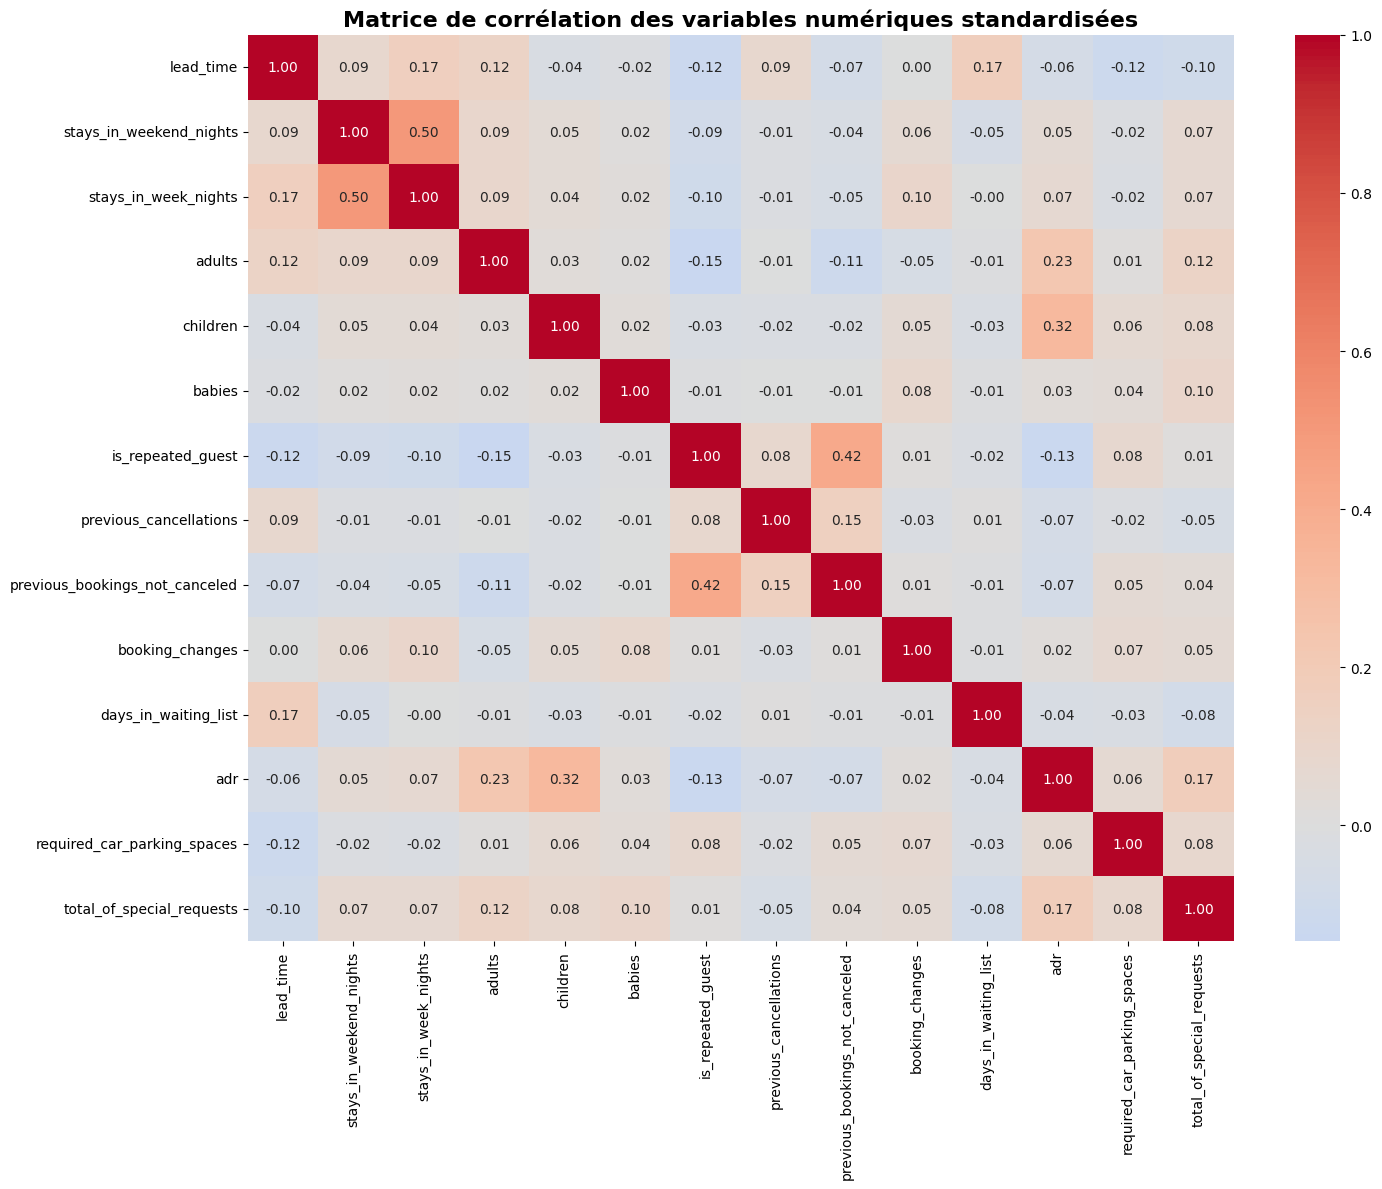

Paires de variables avec |corr| > 0.8 :


,Variable 1,Variable 2,Corrélation


In [16]:
colonnes_numeriques = [col for col in df_num_scaled.columns if col != "room_satisfaction"]

matrice_correlation = df_num_scaled[colonnes_numeriques].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(matrice_correlation, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matrice de corrélation des variables numériques standardisées", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

correlation_forte = (matrice_correlation.where(np.triu(np.ones(matrice_correlation.shape), k=1).astype(bool))
                     .stack()
                     .reset_index())
correlation_forte.columns = ['Variable 1', 'Variable 2', 'Corrélation']
correlation_forte = correlation_forte[correlation_forte['Corrélation'].abs() > 0.8]

print("Paires de variables avec |corr| > 0.8 :")
display(correlation_forte.sort_values(by='Corrélation', key=abs, ascending=False))

Aucune variables hautement corrélées -> **pas de variables numériques otées**.

---

Si des corrélations fortes avaient été trouvées -> **lancer les deux cellules suivantes** qui optimisent la suppression de ces variables par un graphe.

**L'objectif poursuivi** est de ne plus avoir de variables hautement corrélées entre elles (ici |corr| > 0.8) car cela trouble les modèles linéaires, complexifie inutilement nos modèles et cela peut entraîner du sur-appprentissage car les modèles peuvent surpondérer des relations internes pas pertinentes.

In [17]:
G = nx.Graph()
G.add_edges_from(correlation_forte[['Variable 1', 'Variable 2']].values)
variables_a_supprimer = set()

while G.number_of_edges() > 0:
    degres = dict(G.degree())
    variable_plus_connectee = max(degres, key=degres.get)
    variables_a_supprimer.add(variable_plus_connectee)
    G.remove_node(variable_plus_connectee)

print("Nombre de variables supprimées :", len(variables_a_supprimer))

Nombre de variables supprimées : 0


In [18]:
df_num_scaled_optim = df_num_scaled.drop(columns=variables_a_supprimer)

df_final_optim = pd.concat([df_num_scaled_optim, df_cat_encoded], axis=1)
df_final_optim["is_canceled"] = y.values

cols = ["is_canceled"] + [col for col in df_final_optim.columns if col != "is_canceled"]
df_final_optim = df_final_optim[cols]

print("\nForme finale après optimisation par corrélation :", df_final_optim.shape)
display(df_final_optim.head())


Forme finale après optimisation par corrélation : (119390, 49)


,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,room_satisfaction,hotel_City Hotel,hotel_Resort Hotel,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Autre_NR,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_season_Automne,arrival_season_Hiver,arrival_season_Printemps,arrival_season_Été,country_zone_Autre_NR,country_zone_Etranger_AFRIQUE,country_zone_Etranger_AMÉRIQUE,country_zone_Etranger_ASIE,country_zone_Etranger_EUROPE,country_zone_Etranger_OCÉANIE,country_zone_Natif
0,0,2.227051,-0.92889,-1.310240,0.247897,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,4.260101,-0.131924,-2.015038,-0.254873,-0.720694,0.377867,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,5.923385,-0.92889,-1.310240,0.247897,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,5.793131,-0.131924,-2.015038,-0.254873,-0.720694,0.377867,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,-0.907814,-0.92889,-0.786207,-1.478447,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,-0.131924,-0.530935,-0.254873,-0.720694,-2.646435,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,-0.851667,-0.92889,-0.786207,-1.478447,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,-0.131924,-0.530935,-0.254873,-0.720694,0.377867,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,-0.842309,-0.92889,-0.262174,0.247897,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,-0.131924,-0.075810,-0.254873,0.540666,0.377867,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<h1 style="color:gold;">Optimisation en performance</h1>


In [19]:
X = df_final.drop(columns=["is_canceled"])
y = df_final["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)


scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

hyperparam = {
                "LogisticRegression": ParameterGrid({
                                                    "C": [0.01, 0.1, 1, 10],
                                                    "penalty": ["l2"],
                                                    "solver": ["lbfgs"],
                                                    "class_weight": ["balanced"],
                                                    "max_iter": [100, 300]
                                                    })
               ,
               "KNN": ParameterGrid({
                                     "n_neighbors": [3, 5, 7],
                                     "weights": ["uniform", "distance"],
                                     "metric": ["minkowski", "euclidean"]
                                    })
                ,
               "NaiveBayes": ParameterGrid([{}])
               ,
               "RandomForest": ParameterGrid({
                                              "n_estimators": [100, 200],
                                              "max_depth": [None, 10, 20],
                                              "class_weight": ["balanced"],
                                              "random_state": [42]
                                             })
               ,
               "MLP": ParameterGrid({
                                     "hidden_layer_sizes": [(100,), (100, 50)],
                                     "activation": ["relu", "tanh"],
                                     "solver": ["adam"],
                                     "max_iter": [200],
                                     "alpha": [0.0001, 0.001]
                                    })
               ,
                "XGBoost" : ParameterGrid({
                                           "n_estimators": [50, 100, 150],
                                           "learning_rate": [0.1, 0.01, 0.001],
                                           "max_depth": [5, 10],
                                           "subsample": [0.8, 1],
                                           "colsample_bytree": [0.8, 1],
                                           "random_state": [42],
                                           "gamma": [0],
                                           "n_jobs": [-1],
                                           "eval_metric": ["auc"]
                                           })
              }

models = {
          "LogisticRegression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "NaiveBayes": GaussianNB(),
          "RandomForest": RandomForestClassifier(),
          "MLP": MLPClassifier(),
          "XGBoost": xgb.XGBClassifier()
        }


resultats = []

for model_nom, grid in hyperparam.items():
    print(f"\n### Training {model_nom} ###")
    for params in tqdm(grid):
        model = clone(models[model_nom])
        model.set_params(**params)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        result = {
            "model_nom": model_nom,
            "params": params,
            "accuracy": accuracy_score(y_val, y_pred),
            "f1_score": f1_score(y_val, y_pred),
            "roc_auc": roc_auc_score(y_val, y_proba),
            "auc_pr": average_precision_score(y_val, y_proba),
        }
        resultats.append(result)

df_resultats = pd.DataFrame(resultats)
meilleurs_modeles = df_resultats.sort_values(by=["roc_auc", "auc_pr", "f1_score", "accuracy"],ascending=False).head(10)


### Training LogisticRegression ###


100%|██████████| 8/8 [00:01<00:00,  4.16it/s]



### Training KNN ###


100%|██████████| 12/12 [00:43<00:00,  3.61s/it]



### Training NaiveBayes ###


100%|██████████| 1/1 [00:00<00:00,  6.49it/s]



### Training RandomForest ###


100%|██████████| 6/6 [00:54<00:00,  9.02s/it]



### Training MLP ###


  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\gwelo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 12%|█▎        | 1/8 [00:30<03:36, 30.98s/it]c:\Users\gwelo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 25%|██▌       | 2/8 [01:42<05:28, 54.72s/it]c:\Users\gwelo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 38%|███▊      | 3/8 [02:13<03:40, 44.12s/it]c:\Users\gwelo\AppData\Local\Programs\Pyth


### Training XGBoost ###


100%|██████████| 72/72 [00:32<00:00,  2.24it/s]


In [20]:
print("\n### Top modèles sur le set de validation ###")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    print(meilleurs_modeles[["model_nom", "roc_auc", "auc_pr", "accuracy", "f1_score"]])
    print("\n🔧 Hyperparamètres associés :")
    print(meilleurs_modeles[["params"]])


### Top modèles sur le set de validation ###
       model_nom   roc_auc    auc_pr  accuracy  f1_score
22  RandomForest  0.944735  0.922878  0.874864  0.824853
21  RandomForest  0.944067  0.921729  0.875450  0.825346
26  RandomForest  0.943348  0.919836  0.868456  0.822893
81       XGBoost  0.943254  0.919446  0.871304  0.819755
46       XGBoost  0.943178  0.919533  0.871053  0.818914
25  RandomForest  0.943026  0.919484  0.868289  0.822507
45       XGBoost  0.942955  0.919343  0.870299  0.818539
82       XGBoost  0.942085  0.918029  0.869671  0.817027
79       XGBoost  0.941312  0.916637  0.868414  0.815459
43       XGBoost  0.940670  0.916284  0.869294  0.816379

🔧 Hyperparamètres associés :
                                                                                                                                                                         params
22                                                                                     {'class_weight': 'balanced', 'max_

<h1 style="color:gold;">Généralisation</h1>

AUC : 0.9462
Accuracy : 0.8764


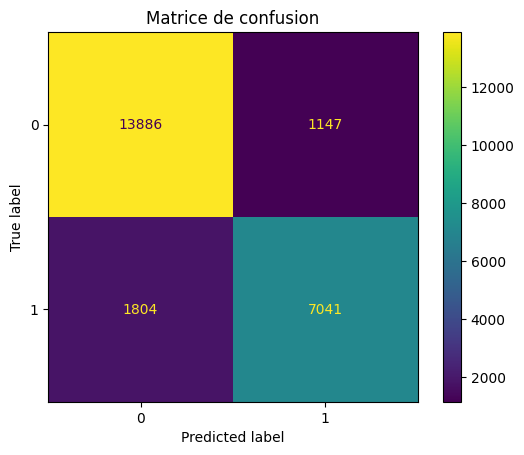

In [26]:
random_forest = RandomForestClassifier(n_estimators=200,max_depth=None,class_weight='balanced',random_state=42)
random_forest.fit(X_train, y_train)

y_proba = random_forest.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.5).astype(int)

auc = roc_auc_score(y_test, y_proba)
print(f"AUC : {auc:.4f}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.4f}")

matrice_confusion = confusion_matrix(y_test, y_pred)
matrice_image = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion)
matrice_image.plot()
plt.title("Matrice de confusion")
plt.show()

<h1 style="color:gold;">Analyse des valeurs SHAP</h1>

In [40]:
feature_names = X_train.columns.tolist()

explainer = shap.Explainer(model, X_train, feature_names=feature_names)
shap_values = explainer(X_test)

shap_values_array = shap_values.values


group_de_features = {
    # Comportement de réservation
    'lead_time': 'Comportement réservation',
    'previous_cancellations': 'Comportement réservation',
    'previous_bookings_not_canceled': 'Comportement réservation',
    'booking_changes': 'Comportement réservation',
    'days_in_waiting_list': 'Comportement réservation',
    'is_repeated_guest': 'Comportement réservation',

    # Caractéristiques du séjour
    'stays_in_weekend_nights': 'Caractéristiques du séjour',
    'stays_in_week_nights': 'Caractéristiques du séjour',
    'adults': 'Caractéristiques du séjour',
    'children': 'Caractéristiques du séjour',
    'babies': 'Caractéristiques du séjour',
    'required_car_parking_spaces': 'Caractéristiques du séjour',
    'total_of_special_requests': 'Caractéristiques du séjour',
    'room_satisfaction': 'Caractéristiques du séjour',
    'adr': 'Caractéristiques du séjour',
    'arrival_season_Automne': 'Caractéristiques du séjour',
    'arrival_season_Hiver': 'Caractéristiques du séjour',
    'arrival_season_Printemps': 'Caractéristiques du séjour',
    'arrival_season_Été': 'Caractéristiques du séjour',

    # Hotel & repas
    'hotel_City Hotel': 'Hotel & repas',
    'hotel_Resort Hotel': 'Hotel & repas',
    'meal_BB': 'Hotel & repas',
    'meal_FB': 'Hotel & repas',
    'meal_HB': 'Hotel & repas',
    'meal_SC': 'Hotel & repas',
    'meal_Undefined': 'Hotel & repas',

    # Segment & type client
    'market_segment_Autre_NR': 'Segment & type client',
    'market_segment_Aviation': 'Segment & type client',
    'market_segment_Complementary': 'Segment & type client',
    'market_segment_Corporate': 'Segment & type client',
    'market_segment_Direct': 'Segment & type client',
    'market_segment_Groups': 'Segment & type client',
    'market_segment_Offline TA/TO': 'Segment & type client',
    'market_segment_Online TA': 'Segment & type client',
    'deposit_type_No Deposit': 'Segment & type client',
    'deposit_type_Non Refund': 'Segment & type client',
    'deposit_type_Refundable': 'Segment & type client',
    'customer_type_Contract': 'Segment & type client',
    'customer_type_Group': 'Segment & type client',
    'customer_type_Transient': 'Segment & type client',
    'customer_type_Transient-Party': 'Segment & type client',

    # Origine géographique
    'country_zone_Autre_NR': 'Origine géographique',
    'country_zone_Etranger_AFRIQUE': 'Origine géographique',
    'country_zone_Etranger_AMÉRIQUE': 'Origine géographique',
    'country_zone_Etranger_ASIE': 'Origine géographique',
    'country_zone_Etranger_EUROPE': 'Origine géographique',
    'country_zone_Etranger_OCÉANIE': 'Origine géographique',
    'country_zone_Natif': 'Origine géographique'
}

100%|===================| 23837/23878 [04:28<00:00]        

Moyenne des SHAP absolus par groupe


,group,mean_abs_shap
3,Origine géographique,0.010415
1,Comportement réservation,0.009608
4,Segment & type client,0.008939
0,Caractéristiques du séjour,0.006635
2,Hotel & repas,0.001161


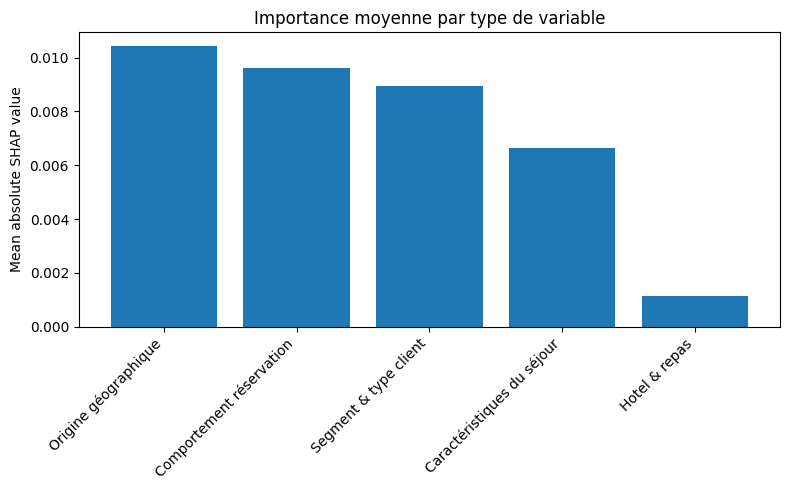

In [41]:
abs_shap = np.abs(shap_values_array)
mean_abs_shap = abs_shap.mean(axis=0)

df_importance = pd.DataFrame({'feature': feature_names,'mean_abs_shap': mean_abs_shap})
df_importance['group'] = df_importance['feature'].map(group_de_features).fillna('Autres')

group_importance = (df_importance.groupby('group')['mean_abs_shap'].mean().reset_index().sort_values('mean_abs_shap', ascending=False))

print("Moyenne des SHAP absolus par groupe")
display(group_importance)

plt.figure(figsize=(8,5))
plt.bar(group_importance['group'], group_importance['mean_abs_shap'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean absolute SHAP value')
plt.title('Importance moyenne par type de variable')
plt.tight_layout()
plt.show()